In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.odr import *
from scipy.optimize import curve_fit
!git clone https://github.com/JCLMantilla/LabIntermedio

Cloning into 'LabIntermedio'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 57 (delta 16), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (57/57), done.


In [ ]:
def get_uncertainty(number):
  number=str(number)
  point_pos=0
  dig=len(number)-1
  for i in range(len(number)):
    if number[i]==".":
      point_pos=i
  uncertainty=1/(10**(abs(dig-point_pos)))
  return uncertainty
def get_uncertainty_dframe(dframe):
  new_dframe=dframe.copy()
  for column in new_dframe.columns:
    for index in new_dframe.index:
      new_dframe.loc[index,column]=get_uncertainty(new_dframe.loc[index,column])
  return new_dframe

53.61872170174381
5.994759700214071
56.329777695461836
6.297865671896849


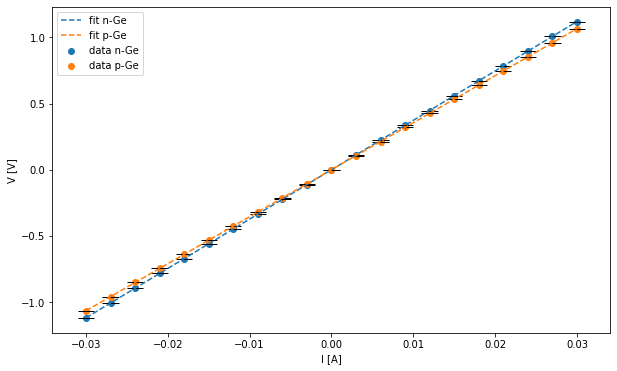

In [ ]:
act3=pd.read_csv(filepath_or_buffer="/content/LabIntermedio/act3.csv",delimiter=";",float_precision="round_trip")
act3=act3.rename(columns={"IN(mA)": "IN", "VLN(V)": "VN","IP(mA)":"IP","VLP(V)":"VP"})
act3["IN"]=act3["IN"]/1000
act3["IP"]=act3["IP"]/1000
#RECORDAR!!!!! I esta en (A) y V en (V)
#act3.dtypes
act3_error=get_uncertainty_dframe(act3)

#plt.figure()
#plt.plot(act3["IN"],act3["VN"])
#plt.plot(act3["IP"],act3["VP"])

###Vamos a echar ScyPy ODR :p
def f(B, x):
    return B[0]*x + B[1]
##################### Fit tipo N #####################     
mydata = RealData( act3["IN"], act3["VN"], sx=act3_error["IN"], sy=act3_error["VN"])
myodr = ODR(mydata, Model(f), beta0=[0,1])
myoutput = myodr.run()
#myoutput.pprint()
pendiente_N,corte_N=myoutput.beta
pendiente_N_error,_=myoutput.sd_beta 
x_fit_N=np.linspace(act3["IN"][0],act3["IN"][len(act3["IN"])-1],100)
y_fit_N=pendiente_N*x_fit_N+corte_N
##################### Fit tipo P ##################### 
mydata = RealData( act3["IP"], act3["VP"], sx=act3_error["IP"], sy=act3_error["VP"])
myodr = ODR(mydata, Model(f), beta0=[0,1])
myoutput = myodr.run()
#myoutput.pprint()
pendiente_P,corte_P=myoutput.beta
pendiente_P_error,_=myoutput.sd_beta 
x_fit_P=np.linspace(act3["IP"][0],act3["IP"][len(act3["IP"])-1],100)
y_fit_P=pendiente_P*x_fit_P+corte_P


plt.figure(figsize=(10,6))
plt.scatter(act3["IN"] , act3["VN"],label="data n-Ge")
plt.errorbar(act3["IN"] , act3["VN"],xerr=0.001,yerr=0.001, ecolor="black",linestyle='--',elinewidth=1,fmt="none")
plt.plot(x_fit_N,y_fit_N, label="fit n-Ge",linestyle="--")

plt.scatter(act3["IP"] , act3["VP"],label="data p-Ge")
plt.errorbar(act3["IP"] , act3["VP"],xerr=0.001,yerr=0.001, ecolor="black",linestyle='--',elinewidth=1,fmt="none")
plt.plot(x_fit_P,y_fit_P, label="fit p-Ge",linestyle="--")

plt.ylabel("V [V]")
plt.xlabel("I [A]")
plt.legend()

#print(pendiente_N)
#print(pendiente_N_error)

#print(pendiente_P)
#print(pendiente_P_error)

longitud=0.02 #en m
longitud_error=0.001
area= 1.0e-5 #en m**2
area_error=1.0e-6

conduc_N=longitud/(pendiente_N*area)
conduc_P=longitud/(pendiente_P*area)

conduc_N_error=np.sqrt((longitud_error/(pendiente_N*area))**2+(pendiente_N_error*longitud/(area*pendiente_N*pendiente_N))**2+(area_error*longitud/(area*area*pendiente_N)          )**2)
conduc_P_error=np.sqrt((longitud_error/(pendiente_P*area))**2+(pendiente_N_error*longitud/(area*pendiente_P*pendiente_P))**2+(area_error*longitud/(area*area*pendiente_P)          )**2)

print(conduc_N)
print(conduc_N_error)
print(conduc_P)
print(conduc_P_error)


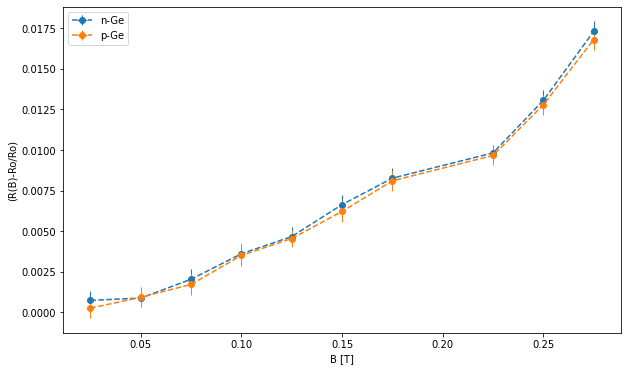

In [ ]:
tipon=pd.read_csv(filepath_or_buffer="/content/LabIntermedio/tipon.csv",delimiter=";",float_precision="round_trip",names=["IN","25","50","75","100","125","150","175","225","250","275"])
tipop=pd.read_csv(filepath_or_buffer="/content/LabIntermedio/tipop.csv",delimiter=";",float_precision="round_trip",names=["IP","25","50","75","100","125","150","175","225","250","275"])
tipon["IN"]=tipon["IN"]/1000
tipop["IP"]=tipop["IP"]/1000

for x in tipon.columns[1:]:
  x_new=float(x)/1000
  tipon=tipon.rename(columns={x:str(x_new)})
  tipop=tipop.rename(columns={x:str(x_new)})
############# Campos magneticos #############
B=np.array([float(x) for x in tipon.columns[1:]])
B_error=np.array([0.001 for x in B])
############# Incertidumbres de los voltajes #############
tipon_error=get_uncertainty_dframe(tipon)
tipop_error=get_uncertainty_dframe(tipop)
############# Vamos a hacer los ajustes para el tipo N #############
def f(B, x):
    return B[0]*x + B[1]
### Listas de las resistencias con sus incertidumbres ###
R_n=[]
R_n_error=[]
for columna in tipon.columns[1:]:
  mydata = RealData( tipon["IN"], tipon[columna], sx=tipon_error["IN"], sy=tipon_error[columna])
  myodr = ODR(mydata, Model(f), beta0=[0,1])
  myoutput = myodr.run()
  pendiente,corte=myoutput.beta
  pendiente_error,_=myoutput.sd_beta
  R_n.append(pendiente)
  R_n_error.append(pendiente_error)

R_n=np.array(R_n)
R_n_error=np.array(R_n_error)
R_n=(R_n-pendiente_N)/pendiente_N
R_n_error=R_n_error/pendiente_N +0.0005

############# Vamos a hacer los ajustes para el tipo P #############
def f(B, x):
    return B[0]*x + B[1]
### Listas de las resistencias con sus incertidumbres ###
R_p=[]
R_p_error=[]
for columna in tipop.columns[1:]:
  mydata = RealData( tipop["IP"], tipop[columna], sx=tipop_error["IP"], sy=tipop_error[columna])
  myodr = ODR(mydata, Model(f), beta0=[0,1])
  myoutput = myodr.run()
  pendiente,corte=myoutput.beta
  pendiente_error,_=myoutput.sd_beta
  R_p.append(pendiente)
  R_p_error.append(pendiente_error)
  
R_p=np.array(R_p)
R_p_error=np.array(R_p_error)
R_p=(R_p-pendiente_P)/pendiente_P
R_p_error=R_p_error/pendiente_P +0.0005


plt.figure(figsize=(10,6))

plt.errorbar(B,R_n,xerr=0.001,yerr=R_n_error,linestyle='--',elinewidth=1,fmt="--o",label="n-Ge")
plt.errorbar(B,R_p,xerr=0.001,yerr=R_p_error,linestyle='--',elinewidth=1,fmt="--o",label="p-Ge")

plt.ylabel("(R(B)-Ro/Ro)")
plt.xlabel("B [T]")

plt.legend()
plt.show()




In [ ]:
tipop

,IP,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.225,0.25,0.275
0,-0.030,-1.065,-1.066,-1.067,-1.069,-1.070,-1.072,-1.073,-1.076,-1.079,-1.083
1,-0.027,-0.959,-0.960,-0.960,-0.962,-0.963,-0.964,-0.966,-0.968,-0.971,-0.975
2,-0.024,-0.852,-0.853,-0.853,-0.855,-0.856,-0.858,-0.859,-0.860,-0.863,-0.867
3,-0.021,-0.746,-0.746,-0.747,-0.748,-0.749,-0.750,-0.751,-0.753,-0.755,-0.758
4,-0.018,-0.639,-0.640,-0.640,-0.641,-0.642,-0.643,-0.644,-0.645,-0.647,-0.650
5,-0.015,-0.533,-0.533,-0.534,-0.534,-0.535,-0.536,-0.537,-0.538,-0.539,-0.541
6,-0.012,-0.426,-0.427,-0.427,-0.428,-0.428,-0.429,-0.430,-0.430,-0.432,-0.433
7,-0.009,-0.320,-0.320,-0.320,-0.321,-0.321,-0.322,-0.322,-0.323,-0.324,-0.325
8,-0.006,-0.213,-0.213,-0.214,-0.214,-0.214,-0.214,-0.215,-0.215,-0.216,-0.217
9,-0.003,-0.107,-0.107,-0.107,-0.107,-0.107,-0.107,-0.107,-0.108,-0.108,-0.108
